# Анализ клиентов сети фитнес-центров «Культурист-датасаентист»  

**Цель** - провести анализ клиентов сети относительно оттока клиентов.

Для прогнозирования оттока клиентов была создана модель Случайного леса. Для кластеризации клиентов была создана модель, основанная на алгоритме k-средних.  

**Входные данные**:
- Churn — факт оттока в текущем месяце
- gender — пол
- Near_Location — проживание или работа в районе, где находится фитнес-центр
- Partner — сотрудник компании-партнёра клуба
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга»
- Phone — наличие контактного телефона
- Age — возраст
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)
- Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
- Group_visits — факт посещения групповых занятий
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра  

**Содержание**:
- <a href="#Импорт-необходимых-библиотек">Импорт необходимых библиотек</a>
- <a href="#Загрузка-данных-и-знакомство-с-ними">Загрузка данных и знакомство с ними</a>
- <a href="#Исследовательский-анализ-данных">Исследовательский анализ данных</a>
- <a href="#Прогнозирование-оттока-клиентов">Прогнозирование оттока клиентов</a>
- <a href="#Кластеризация-клиентов">Кластеризация клиентов</a>
- <a href="#Вывод">Вывод</a>

### Импорт необходимых библиотек

Импортируем библиотеки

In [3]:
import pandas as pd
# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# Инструменты
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Бинарная классификация
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Кластеризация
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

### Загрузка данных и знакомство с ними

Загрузим данные

In [4]:
gym_churn = pd.read_csv('gym_churn.csv')
gym_churn.name = 'Gym churn'

Создадим вспомогательную функцию, которая позволит быстро ознакомиться с данными

In [5]:
def first_look(df, sample_size=5):
    print(f'\nДатафрейм {df.name}:')
    display(df.sample(sample_size))
    df.info()
    
    na_count = df.isna().sum()
    duplicates_count = df.duplicated().sum()
    
    print('\nКоличество пропусков в столбцах:')
    print(na_count)
    print('\nКоличество дубликатов: ', duplicates_count)
    print('----------------------------------')

Ознакомимся с данными

In [6]:
first_look(gym_churn)


Датафрейм Gym churn:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1895,1,1,0,1,1,1,1,31,0.410893,1.0,2,0.686252,0.556895,1
3741,1,1,0,0,1,1,1,35,76.356216,1.0,7,2.188190,2.128462,0
3461,1,1,0,0,1,1,0,33,66.419500,1.0,1,2.739334,2.670374,0
727,0,0,1,0,1,1,0,29,109.153117,1.0,5,1.796118,1.798138,0
1160,1,0,0,0,1,1,0,25,6.251301,1.0,2,1.811955,1.434295,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Приведем названия столбцов к нижнему регистру.

In [7]:
gym_churn.columns = [column.lower() for column in gym_churn.columns]

**Вывод**: данные хорошего качества, предобработка не требуется.

### Исследовательский анализ данных

Исследуем данные. Изучим характеристики параметров. Обратим внимание только на *небинарные* параметры.

In [8]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


По данной таблице составили портрет среднестатистического клиента:
- 29 лет
- Живет в том же районе, в котором находится фитнес-центр
- Тратит 147 у.е. на дополнительные услуги
- В фитнес-центр ходит почти 2 раза в неделю

Другие среднестатистические данные о клиентах:
- Соотношение мужчин и женщин: 51 к 49 (кого больше пока неизвестно)
- Почти 50% клиентов являются сотрудниками компаний-партнёров
- Почти треть клиентов впервые пришли в рамках акции "Приведи друга"
- 41% клиентов посещает групповые занятия
- Средний "возраст" клиента - почти 4 месяца

Все параметры, кроме параметра *age* имеют достаточно большое стандартное отклонение. Видимо датасет включает совершенно разных клиентов.  

Кроме того, параметры имеют совершенно разные диапазоны значений, поэтому перед обучением каких-либо моделей необходимо провести стандартизацию.

Взглянем на средние значения параметров в двух группах - тех, кто ушел в отток и тех, кто остался. *not_churned* - колонка параметров оставшихся клиентов.

In [9]:
grouped_by_churn = gym_churn.pivot_table(columns=['churn'], aggfunc='mean').reset_index()
grouped_by_churn.columns = ['feature', 'not_churned', 'churned']
grouped_by_churn

,feature,not_churned,churned
0,age,29.976523,26.989632
1,avg_additional_charges_total,158.445715,115.082899
2,avg_class_frequency_current_month,2.027882,1.044546
3,avg_class_frequency_total,2.024876,1.474995
4,contract_period,5.747193,1.728558
5,gender,0.510037,0.510839
6,group_visits,0.464103,0.268615
7,lifetime,4.711807,0.990575
8,month_to_end_contract,5.283089,1.662582
9,near_location,0.873086,0.768143


У клиентов, не ушедших в отток, средние значения параметров "лучше", чем у ушедших клиентов. Они больше тратят на дополнительные услуги, чаще ходят в зал, посещают групповые занятия и т.д..  

Отдельно для каждой группы и для каждого признака построим гистограмму. Где уместно отобразим форму распределения.

In [10]:
churned = gym_churn[gym_churn['churn'] == 1]
not_churned = gym_churn[gym_churn['churn'] == 0]

c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

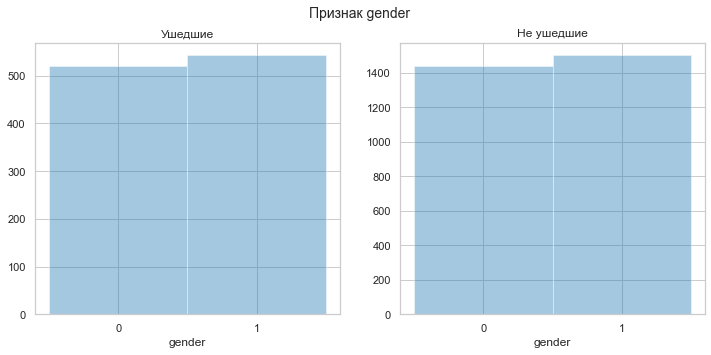

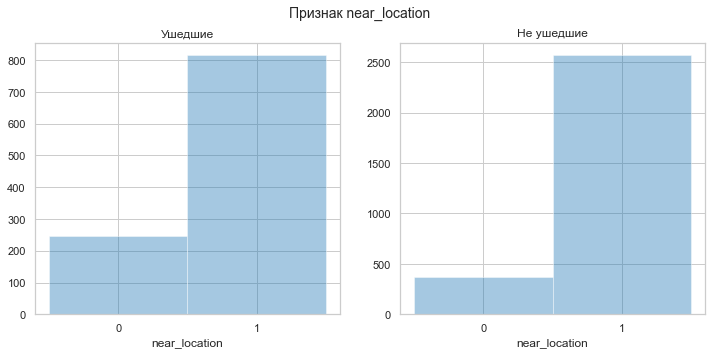

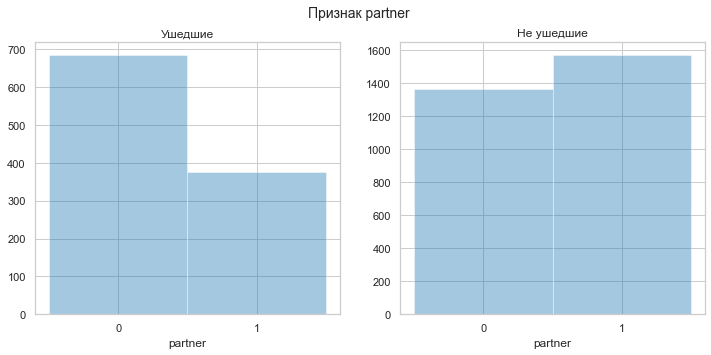

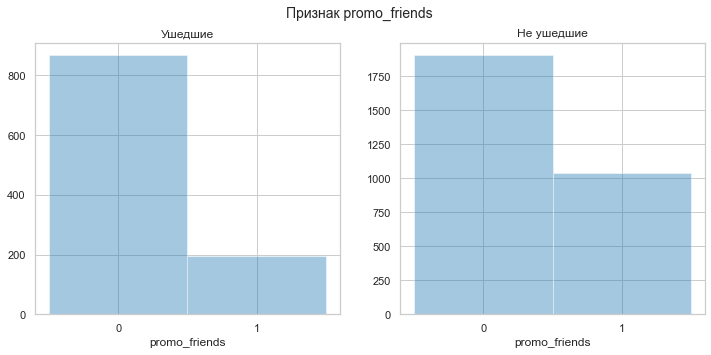

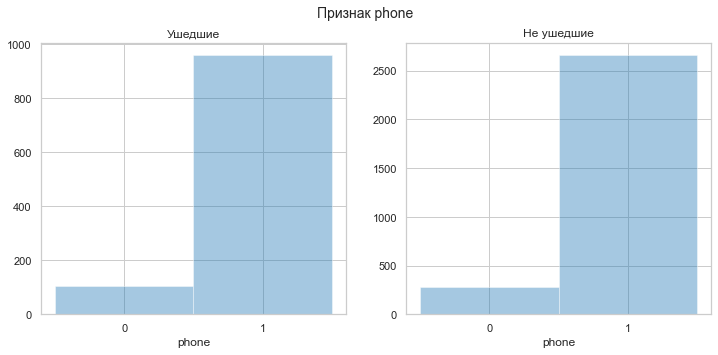

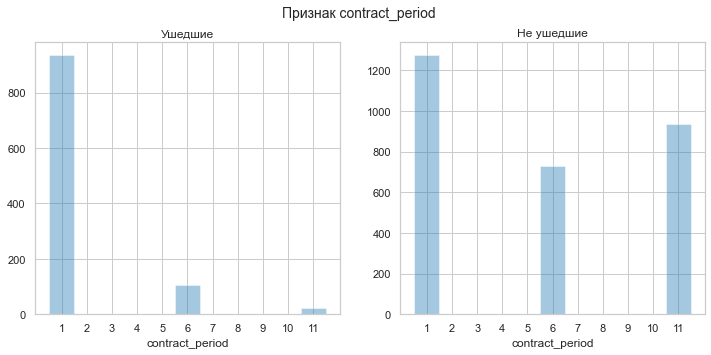

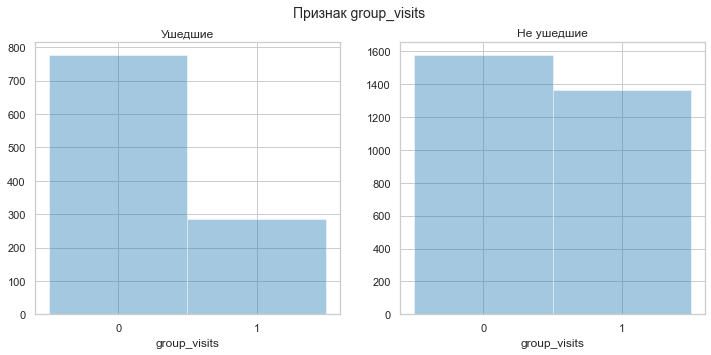

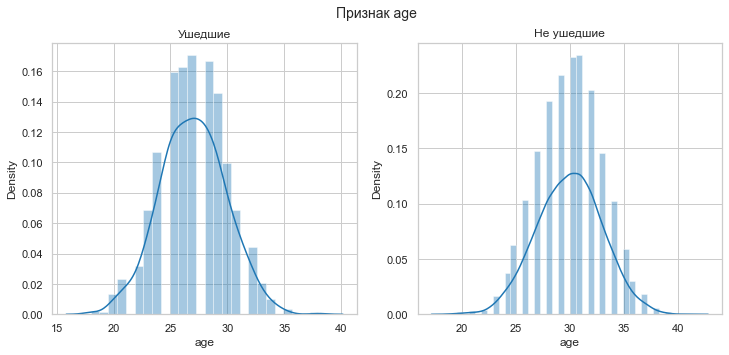

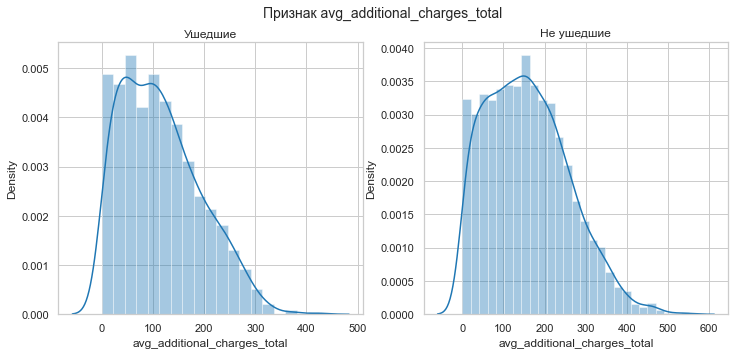

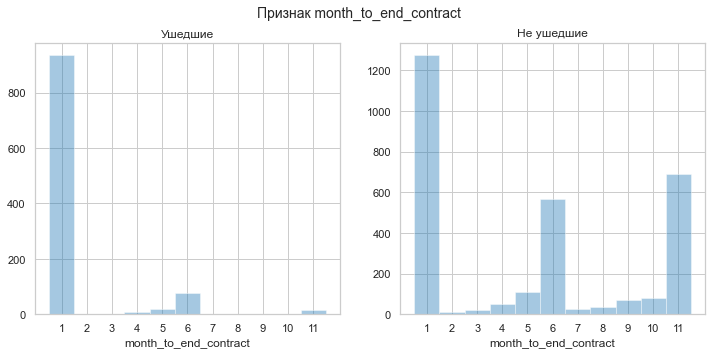

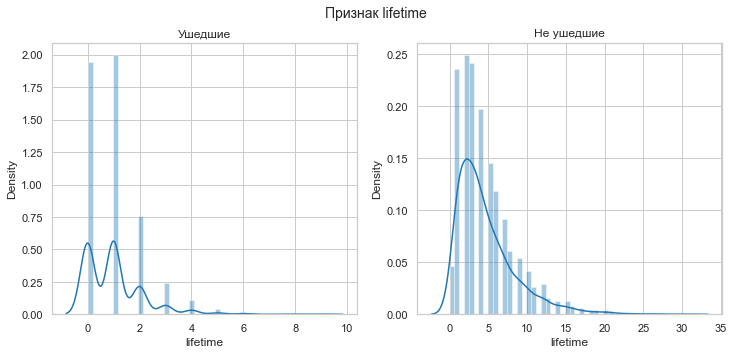

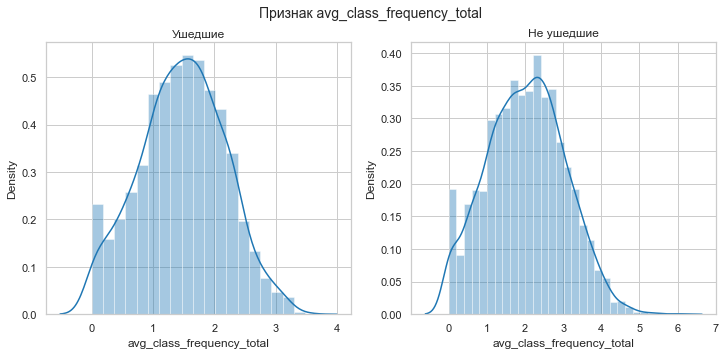

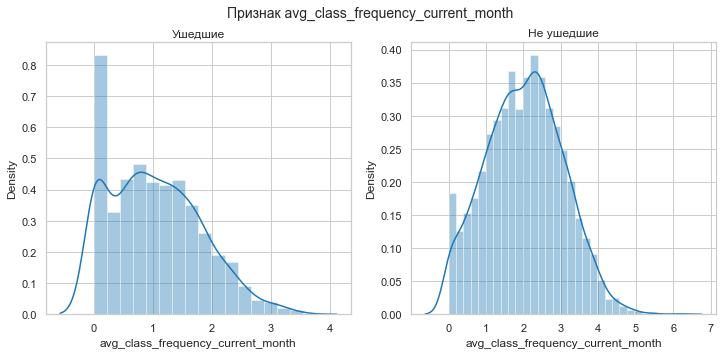

In [11]:
cat_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
num_columns = [ 
    'age', 
    'avg_additional_charges_total', 
    'lifetime', 
    'avg_class_frequency_total', 
    'avg_class_frequency_current_month'
]
sns.set_style('whitegrid')
sns.set_context('notebook')

# Параметры гистограммы, зависящие от признака
cat_options = {
    "bins": 2,
    "kde": False
}

twelve_month_options = {
    "bins": 11,
    "kde": False
}

num_options = {
    "bins": None,
    "kde": True
}

for column in gym_churn.drop('churn', axis=1).columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Признак {column}', fontsize=14)
    
    for ax, df, title in zip(axes, [churned, not_churned], ['Ушедшие', 'Не ушедшие']):
        
        # Выбор параметров гистограммы
        if column in cat_columns:
            options = cat_options
            ax.set_xticks(ticks=[0.25, 0.75])
            ax.set_xticklabels([0, 1])
        elif column in num_columns:
            options = num_options
        else:
            options = twelve_month_options
            ax.set_xticks(ticks=[x+0.5 for x in range(1,12)])
            ax.set_xticklabels(range(1, 12))

        ax.set_title(title)
        sns.distplot(df[column], ax=ax, **options)

Данные гистограммы подтверждают выводы, сделанные ранее. 

Отметим, что не все параметры имеют нормальное распределение. Поэтому при обучении моделей необходимо использовать стандартизацию.  

Построим матрицу корреляции. Будем считать модули коэффициентов корреляции.

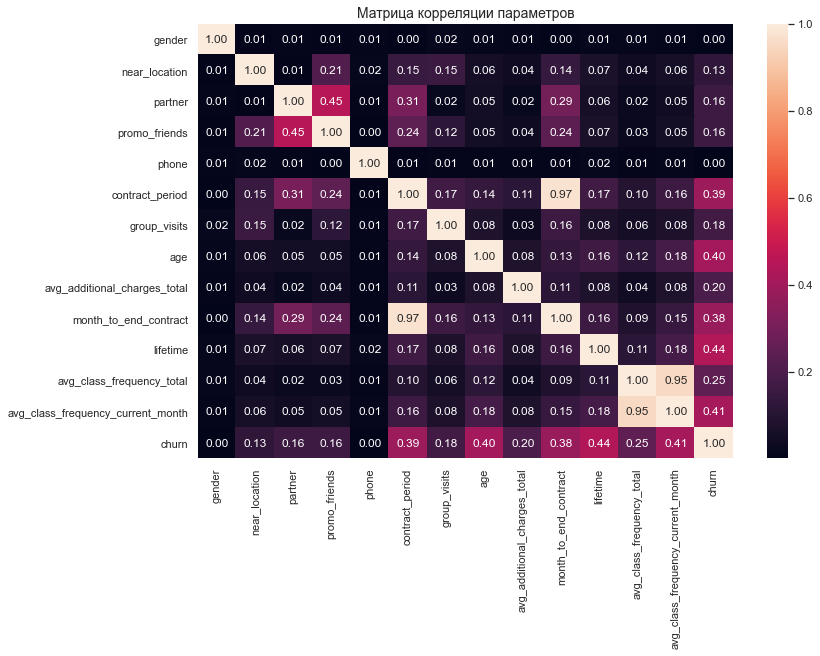

In [12]:
plt.figure(figsize=(12,8))
plt.title('Матрица корреляции параметров', fontdict={'fontsize':14})
sns.heatmap(abs(gym_churn.corr()), annot=True, fmt='.2f');

Параметры, достаточно сильно влияющие на целевую переменную (churn):
- contract_period
- age
- month_to_end_contract
- lifetime
- avg_class_frequency_current_month

Видим 2 пары сильно коррелирующих параметров:
- avg_class_frequency_current_month и avg_class_frequency_total
- month_to_end_contract и contract_period  

Из каждой пары удалим один из параметров, который меньше влияет на целевую переменную.  

In [13]:
gym_churn = gym_churn.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

**Вывод**:  
- Значения параметров соответствуют группам клиентов: у активных клиентов значения "лучше", у ушедших - "хуже"
- Удалены 2 параметра, которые сильно коррелировали с другими параметрами

### Прогнозирование оттока клиентов

При прогнозировании оттока клиентов мы имеем дело с бинароной классификацией - клиент либо уйдет, либо нет. Создадим 2 модели, воспользовавшись логистической регрессией и случайным лесом.    

Разделим данные на параметры и целевую переменную.

In [14]:
X = gym_churn.drop('churn', axis=1)
y = gym_churn['churn']

Переменные и целевую переменную разделим на обучающую и валидационную выборки в соотношении 80 к 20.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, stratify=y)

Создадим и обучим стандартизатор - объект StandardScaler. Трансформируем обучающую и валидационную выборки.

In [16]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

X_test_st = scaler.transform(X_test)

Обучим модель с линейной регрессией.

In [17]:
lr_model = LogisticRegression(solver='liblinear', random_state = 0)

lr_model.fit(X_train_st, y_train);

Обучим модель со случайным лесом.

In [18]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

rf_model.fit(X_train_st, y_train);

Оценим результаты моделей. Оценивание будем проводить на основе метрик Accuracy, Precision и Recall.

In [19]:
for model, model_name in [(lr_model, 'Linear Regression'), (rf_model, 'Random Forest')]:
    y_pred = model.predict(X_test_st)
    
    print(f'{model_name} scores:')
    print(f'\tAccuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(f'\tPrecision: {precision_score(y_test, y_pred):.2f}')
    print(f'\tRecall: {recall_score(y_test, y_pred):.2f}')
    print()

Linear Regression scores:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84

Random Forest scores:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.77



Метрика Accuracy тут не совсем показательна. Она требует примерно равное соотношение классов, а у нас экземпляров одного класса в 3 раза больше, чем экзепляров другого класса.  

Метрики точности и полноты (precision и recall) похожи. У первой модели немного выше recall, а у второй - precision. Метрика Precision в данной задаче важнее, так как клиенту, для которого будет спрогнозирован уход, скорее всего будут предложены более выгодные условия. Поэтому важно минимизировать вероятность напрасного предложения выгодных условий клиентам, которые не собираются уходить.  

**Вывод**: Модель со случаным лесом показала себя лучше.

### Кластеризация клиентов

Проведем кластеризацию клиентов.  

Для кластеризации стандартизация крайне важна, поэтому проведем ее. На стандартизованной матрице признаков построим матрицу расстояний.

In [20]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

Построим дендрограмму.

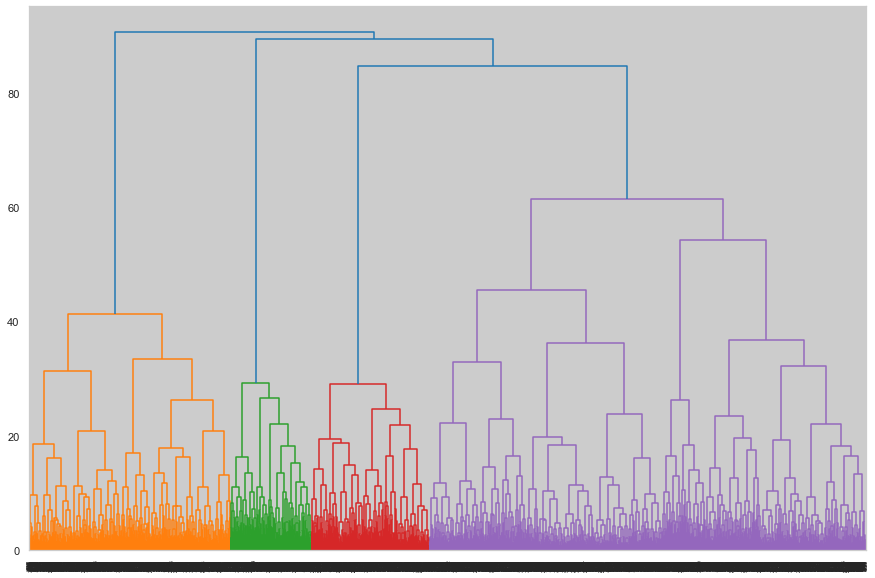

In [21]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

По данной дендрограмме можно выделить 4 больших кластера клиентов. (но по заданию возьмем 5).  

Для кластеризации воспользуемся методом k-средних. Номера кластеров занесем в столбец *cluster* исходного датафрейма.

In [22]:
km = KMeans(n_clusters = 5, random_state=0)

labels = km.fit_predict(X_sc)

gym_churn['cluster'] = labels

Построим таблицу со средними значениями параметров для каждого кластера.

In [23]:
gym_churn.pivot_table(columns=['cluster'], aggfunc='mean')

cluster,0,1,2,3,4
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
avg_class_frequency_current_month,1.919520,1.597146,1.203319,2.324220,1.723967
churn,0.119797,0.403226,0.563910,0.014896,0.266839
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
gender,0.496447,0.500000,0.500940,0.534260,0.523316
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
lifetime,4.283249,2.974910,1.922932,5.415094,3.940415
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503


Основное внимание надо обратить на параметр churn. Это целевая переменная, у которой значение 1 означает отток клиента. Чем больше среднее значение у данного параметра - тем больше клиентов в данном кластере ушли.  

Выделяются кластеры 1 и 2. В них ушли 40% и 56% клиентов соответственно. Если посмотреть на средние значенния других параметров, то видна причина - параметры, оказывающие наибольшее влияние на целевую переменную имеют "плохие" значения.  

Самые надёжные кластеры - 0 и 3.  

Построим распределения признаков для кластеров.

<ipython-input-24-59578e35a7be>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 1])
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-24-59578e35a7be>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 1])
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-24-59578e35a7be>:37: 

<ipython-input-24-59578e35a7be>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 1])
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-24-59578e35a7be>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 1])
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-24-59578e35a7be>:37: 

c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

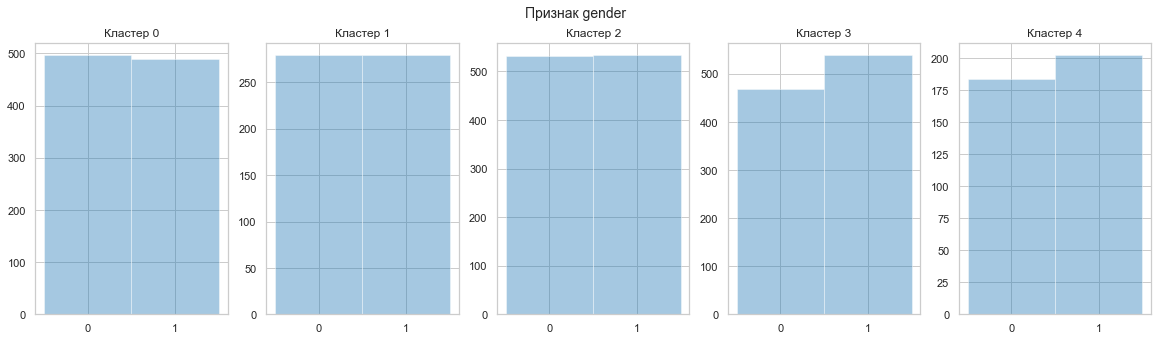

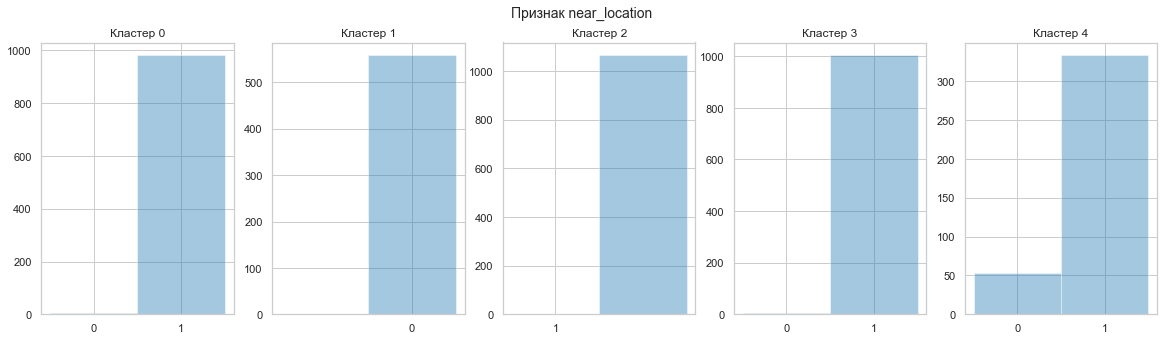

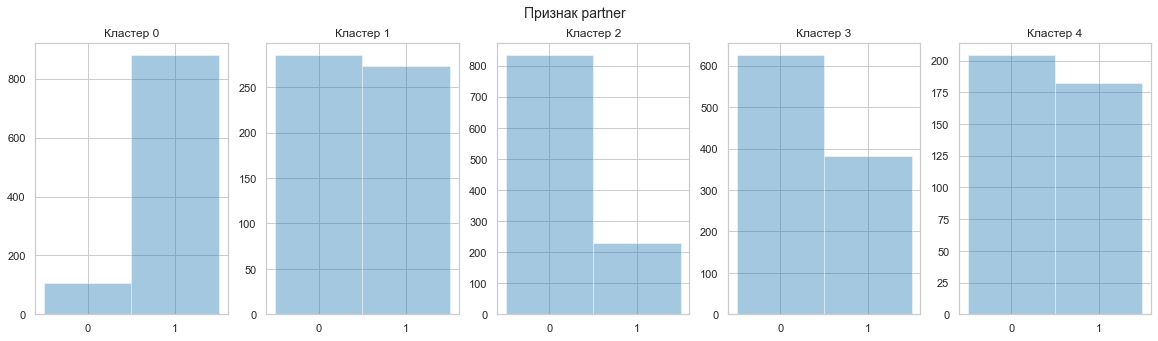

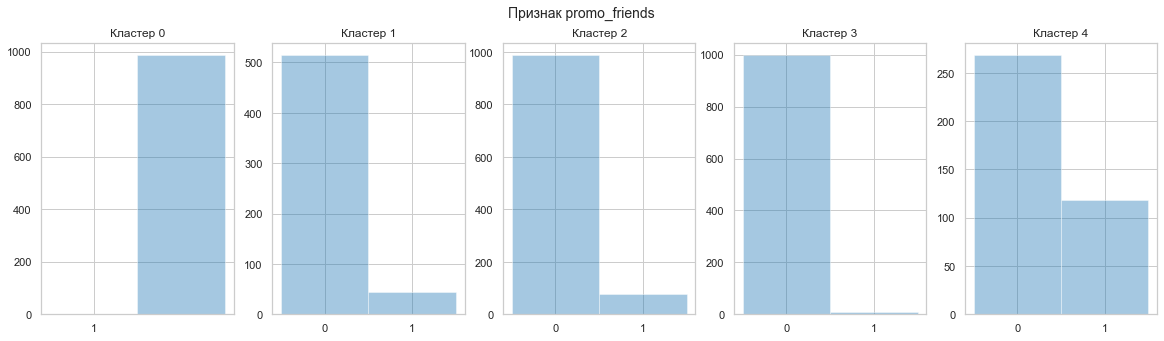

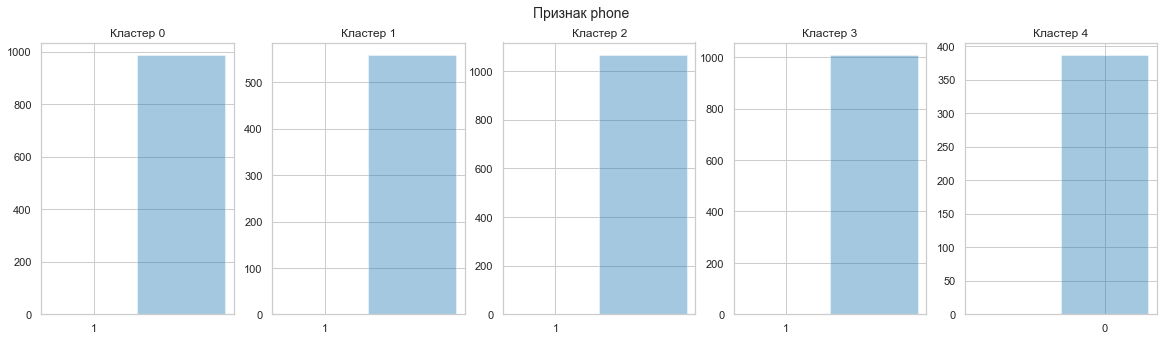

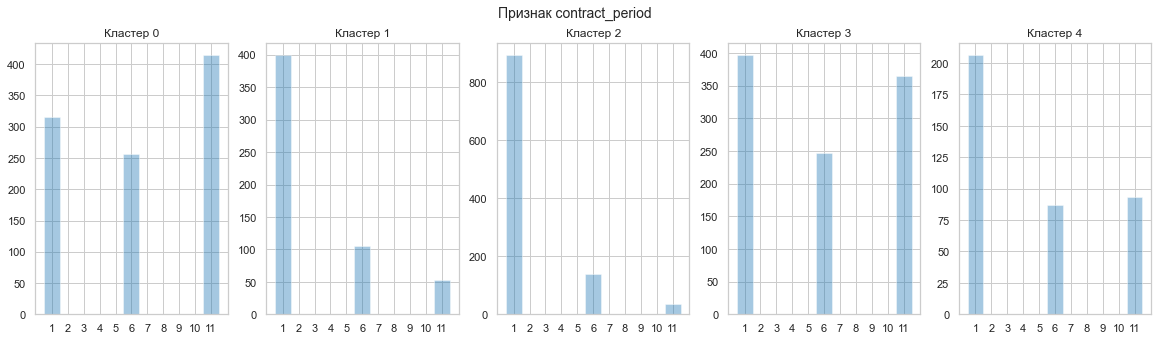

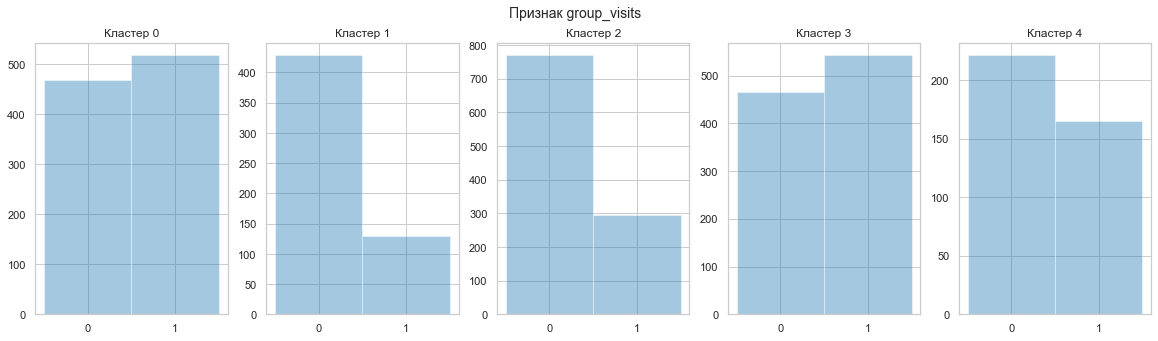

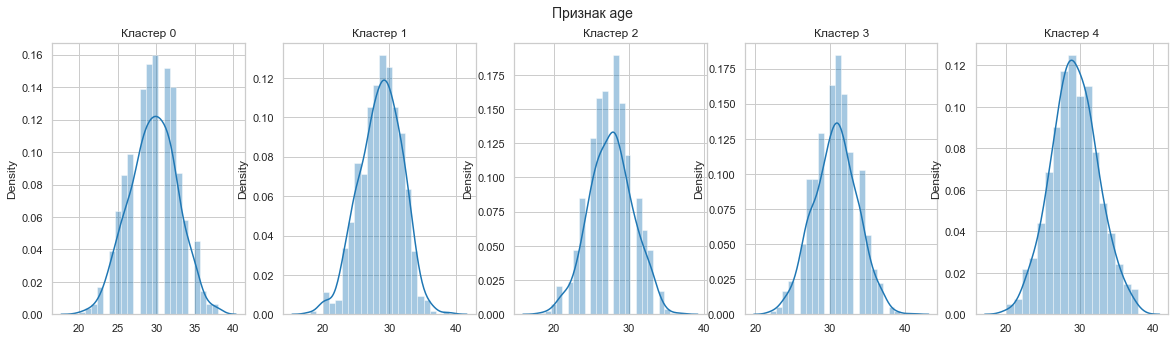

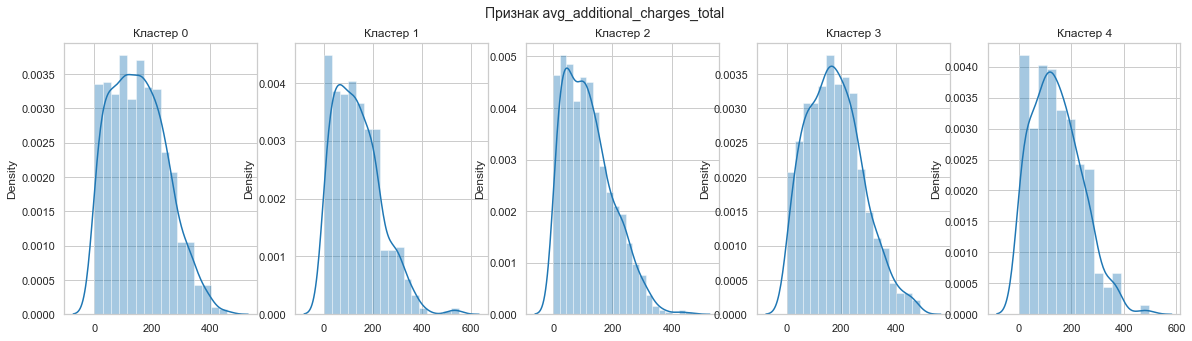

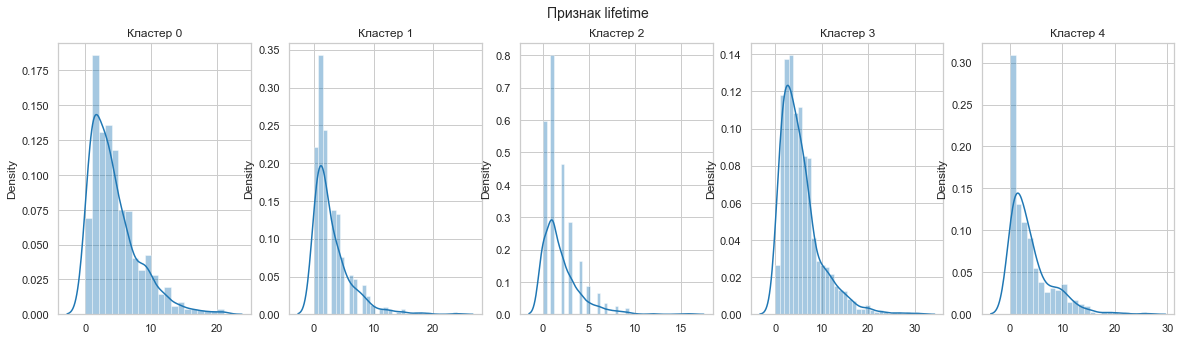

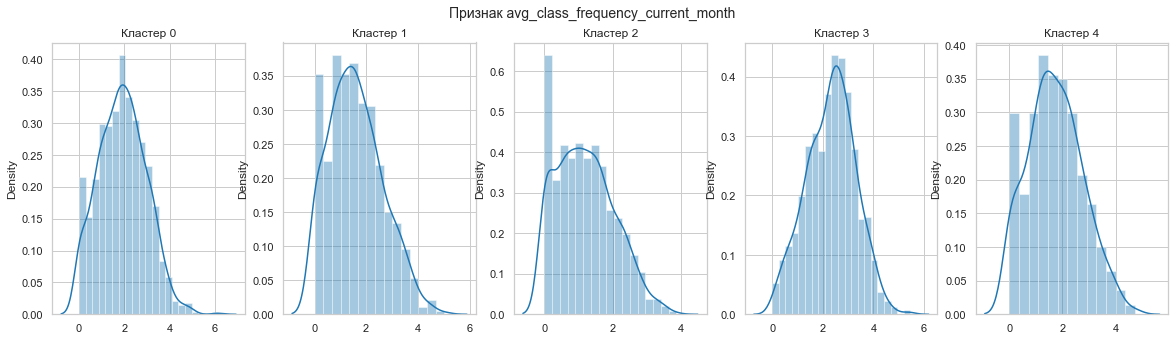

In [24]:
cat_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
num_columns = [ 
    'age', 
    'avg_additional_charges_total', 
    'lifetime', 
    'avg_class_frequency_total', 
    'avg_class_frequency_current_month'
]
sns.set_style('whitegrid')
sns.set_context('notebook')

# Параметры гистограммы, зависящие от признака
cat_options = {
    "bins": 2,
    "kde": False
}

twelve_month_options = {
    "bins": 11,
    "kde": False
}

num_options = {
    "bins": None,
    "kde": True
}

for column in gym_churn.drop(['churn', 'cluster'], axis=1).columns:
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle(f'Признак {column}', fontsize=14)
    
    for (ax, cluster) in zip(axes, range(5)):
        
        # Выбор параметров гистограммы
        if column in cat_columns:
            options = cat_options
            ax.set_xticklabels([0, 1])
            ax.set_xticks(ticks=[0.25, 0.75])
        elif column in num_columns:
            options = num_options
        else:
            options = twelve_month_options
            ax.set_xticks(ticks=[x+0.5 for x in range(1,12)])
            ax.set_xticklabels(range(1, 12))

        ax.set_title(f'Кластер {cluster}')
        
        sns.distplot(gym_churn.loc[gym_churn['cluster'] == cluster, column], ax=ax, **options)
        ax.set(xlabel="")

По построенным распределениям можно понять, какое распределение какого параметра характерно для того или иного кластера. "Ненадежные" кластеры 1 и 2 имеют схожие распределения почти у всех параметров, самые "надежные" (кластеры 0 и 3) также имеют схожие распределения параметров.

Опишем профили кластеров. Будем описывать только параметры, значения которых сильно отличаются от кластера к кластеру.  

|  Параметр  |  Кластер 0  |  Кластер 1  |  Кластер 2  |  Кластер 3  |  Кластер 4  |
|  --------  |  ---------  |  ---------  |  ---------  |  ---------  |  ---------  |
|  Доля клиентов, живущих поблизости  |  99%  |  0%  |  100%  |  99%  | 86%  |
|  Доля клиентов-сотрудников компаний-партнёров  |  89%  |  49%  |  22%  |  37%  | 47%  |
|  Доля воспользовавшихся акцией "Приведи друга"  |  100%  |  7%  |  7%  |  1%  | 30%  |
|  Доля клиентов, указавших номер телефона  |  100%  |  100%  |  100%  |  100%  | 0%  |
|  Доля клиентов, посетивших групповые занятия  |  52%  |  24%  |  28%  |  54%  | 43%  |
|  Средняя длительность абонемента (месяцев)  |  7  |  3  |  2  |  6.2  | 4.8  |
|  Траты на дополнительные услуги  |  153  |  137  |  119  |  176  | 144  |
|  "Возраст" клиента (месяцев)  |  4.3  |  3  |  2  |  5.4  |  4  |
|  Среднее количество посещений в неделю  |  1.9  |  1.6  |  1.2  |  2.3  | 1.7  |



Построим столбчатую диаграмму, отображающую "надежность" клиентов каждого кластера.

In [25]:
cluster_churn = gym_churn.groupby('cluster')[['churn']].mean().reset_index().round(2)

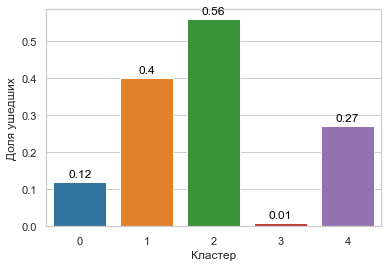

In [26]:
sns.barplot(x=cluster_churn['cluster'], y=cluster_churn['churn'])
plt.xlabel('Кластер')
plt.ylabel('Доля ушедших')

for x, y in zip(range(len(cluster_churn['churn'])), cluster_churn['churn']):
    plt.annotate(y, (x,y), textcoords="offset points", xytext=(0,5), ha='center', color='black', fontsize=12)

plt.show()

**Вывод**: Как и было сказано ранее, кластеры 0 и 3 самые "надежные". Кластеры 1 и 2 самые "ненадежные".

### Вывод

**Предобработка** - данные были хорошего качества, предобработка не потребовалась.  

**Исследовательский анализ данных**:  
- У ушедших клиентов некоторые параметры имеют "плохие" значения:
    - Они совершают мало посещений на неделе
    - Они в основном заключают договор на 1 месяц
- У оставшихся клиентов параметры имеют "хорошие" значения
- Параметры, достаточно сильно влияющие на целевую переменную (churn):
    - contract_period
    - age
    - month_to_end_contract
    - lifetime
    - avg_class_frequency_current_month
- 2 пары сильно коррелирующих параметров:
    - avg_class_frequency_current_month и avg_class_frequency_total
    - month_to_end_contract и contract_period

**Прогнозирование оттока клиентов**:
Были обучены 2 модели прогнозирования - Линейная регрессия и Случайный лес. Немного лучше себя показала модель Случайного леса.  
Её метрики:
- Accuracy: 0.91
- Precision: 0.85
- Recall: 0.77

**Кластеризация клиентов**:
Была обучена модель кластеризации на основе алгоритма k-средних. Было решено выполнять разбиение на 5 кластеров. Ниже указаны доли оставшихся пользователей в каждом кластере:  
- Кластер 0: 88%
- Кластер 1: 60%
- Кластер 2: 44%
- Кластер 3: 99%
- Кластер 4: 73%  

**Рекомендации по работе с клиентами**:
- Клиенты, оформляющие абонемент на длительный срок и, посещающие групповые занятия - очень надежные. Поэтому надо предлагать какие-то бонусы при оформлении абонемента на более длительный срок (более 6 месяцев). Например, можно предлагать скидку на групповые занятия или включать их бесплатно.
- Развивать B2B сегмент, так как клиенты, являющиеся сотрудниками компаний-партнёров также надежны.
- Предлагать молодым клиентам скидки на дополнительные услуги (кафе, спорт-товары и т.д.). Это может повысить надёжность молодых клиентов, которые не пока не пользуются доп. услугами.
- Отслеживать клиентов, у которых абонемент заканчивается на следующей неделе. Если для такого клиента предсказывается отток, то стоит подготовить специальные предложения.
- Протестировать акцию "При каждом третьем посещении фитнес-центра - кофе или чай в подарок". Это может увеличить среднее количество посещений в неделю. А люди с б*о*льшим количеством посещений надёжнее.